In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
import graphviz
from graphviz import render
from graphviz import Source
import numpy as np
from sklearn.cluster import KMeans

Load the Wisconsin Breast Cancer dataset (available on Kaggle) from an Excel file into a pandas DataFrame. This dataset contains measurements computed from digitized images of fine needle aspirate (FNA) biopsies of breast masses. Each row represents a tumor, described by features like radius, texture, perimeter, and smoothness. The target column, diagnosis, tells us whether the tumor was Malignant (M) or Benign (B).

In [14]:
# Get breast cancer data
breast_cancer_df = pd.read_excel('/content/breast_cancer_tumors.xls')

# separating features from id and diagnosis
features = list(breast_cancer_df)
non_feature = ['id','diagnosis']
for item in non_feature:
    features.remove(item)

features_values = breast_cancer_df.loc[:, features].values

Standardize the features. This is needed because different features are on different scales. PCA weighs features with relatively high variably values heavily. Use StandardScaler to standardize the dataset’s features onto unit scale (mean = 0 and variance = 1)

In [15]:
# Standarizing the features, PCA weighs feature with higher deviation heavily.
std_features_values = StandardScaler().fit_transform(features_values)
std_breast_df = pd.DataFrame(data = std_features_values, columns = features)


 Perform PCA: n_components=None is used to compute all possible principal components (30, one for each feature, in this case). Each principal component (PC) is a new axis in the data space that captures as much remaining variance as possible, uncorrelated with the previous ones. The result is a 569×30 matrix — same number of samples, but now expressed in a new coordinate system defined by variance patterns, not original measurements.

In [16]:
#performing PCA
pca_breast = PCA(n_components=None)
pc_breast = pca_breast.fit_transform(std_features_values)

#Putting PCA results into DataFrame
pc_breast_df = pd.DataFrame(data = pc_breast)
pc_column_names =[]
for i in range (0, len(pc_breast_df.columns)):
    pc_column_names.append ('PC'+str(i+1))
pc_breast_df.columns = pc_column_names

print('PC matrix shape: ',  pc_breast_df.shape)

PC matrix shape:  (569, 30)


Compute and visualize the explained variance ratio, we can see that just the first two principal components capture ~63.2% of all the variance in the 30-feature dataset.

variance explained by the first two components: 0.6324320765155944


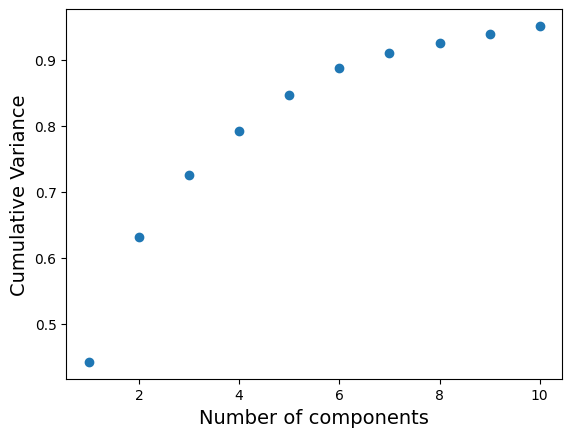

In [17]:
# Get variance corresponding to each PC
pc_variance = pca_breast.explained_variance_ratio_

# Function: plot_cum_var
# this function plots PC cumulative variance vs number of PCs
# inputs: PC variance output
# number of PC used for the plot
# output: plot of PC cumulative variance vs number of PCs

def plot_cum_var (pc_variance, PC_num):
    cum_var = 0
    cum_var_comp = []
    for variance in pc_variance:
        cum_var += variance
        cum_var_comp.append (cum_var)

    pc_nums = []
    for i in range (1, PC_num + 1):
        pc_nums.append(i)
    fig = plt.figure()
    plt.plot(pc_nums,cum_var_comp[:PC_num], 'o')
    plt.xlabel ('Number of components',fontsize=14)
    plt.ylabel ('Cumulative Variance', fontsize=14)

    return fig
# For the first 10 components, plot the total variance
# explained against the number of components included.

plot_cum_var(pc_variance, 10)
print ('variance explained by the first two components:', pc_variance[0]+pc_variance[1])

Plot PC2 by PC1 and color the points by the classification of tumor

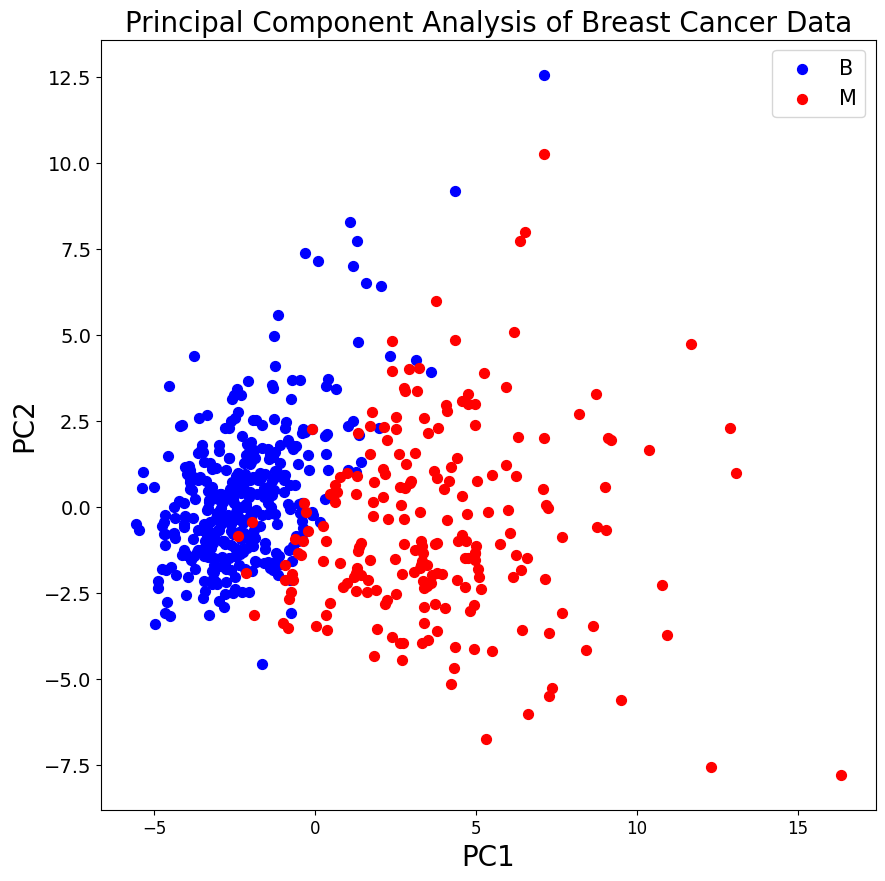

In [18]:
# Plot PC2 by PC1 and color the points
# by the classification of tumor.
fig = plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('PC1',fontsize=20)
plt.ylabel('PC2',fontsize=20)
plt.title("Principal Component Analysis of Breast Cancer Data",fontsize=20)
targets = ['B', 'M']
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indices = breast_cancer_df['diagnosis'] == target
    plt.scatter(pc_breast_df.loc[indices, 'PC1'], pc_breast_df.loc[indices, 'PC2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})

Plot the loadings for PC1 and PC2. The loadings are the contributions of each feature to the principal components. feature contributing the most to PC1: concave points_mean
feature contributing the most to PC2: fractal_dimension_mean
Identified by finding the max loading absolute value for PC1 and PC2 separately or by looking at the graph.

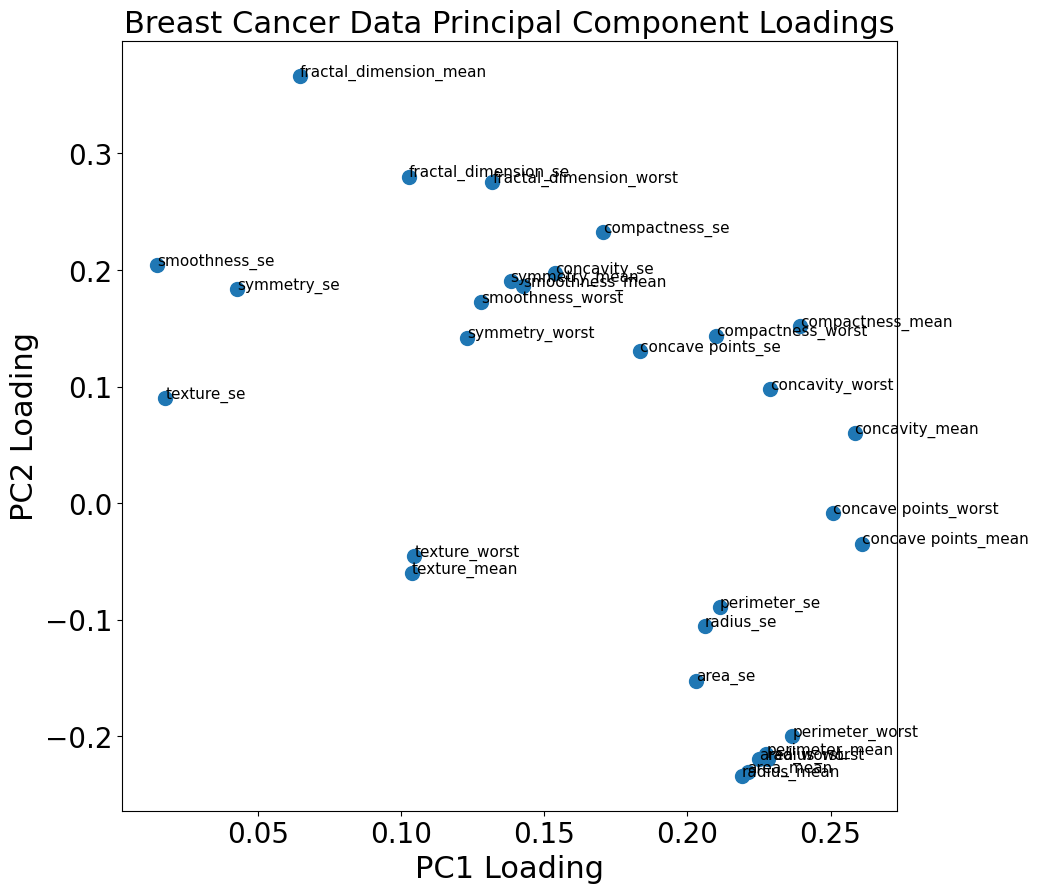

In [19]:
# Get loading
loadings = pd.DataFrame(pca_breast.components_.T)

# Plot the loadings for PC1 and PC2.
fig = plt.figure(figsize=(10,10))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('PC1 Loading',fontsize=22)
plt.ylabel('PC2 Loading',fontsize=22)
plt.title("Breast Cancer Data Principal Component Loadings",fontsize=22)

plt.scatter(loadings[0], loadings[1], s = 100)
for i, label in enumerate(features):
   plt.annotate(label, (loadings[0][i], loadings[1][i]), fontsize= 11)

In [20]:
# Get the two features contribute most to PC1 and PC2
# by taking the max loading absolute value for PC1 and PC2 separately
index_PC1 = list(loadings[0]).index(max(loadings[0], key=abs))
print ('feature contributing the most to PC1:', features[index_PC1])
index_PC2 = list(loadings[1]).index(max(loadings[1], key=abs))
print ('feature contributing the most to PC2:', features[index_PC2])

feature contributing the most to PC1: concave points_mean
feature contributing the most to PC2: fractal_dimension_mean


plot an X-Y scatter of the two features identified contributing the most to PC1 and PC2. The two groups separate but not completely, there is some overlap.

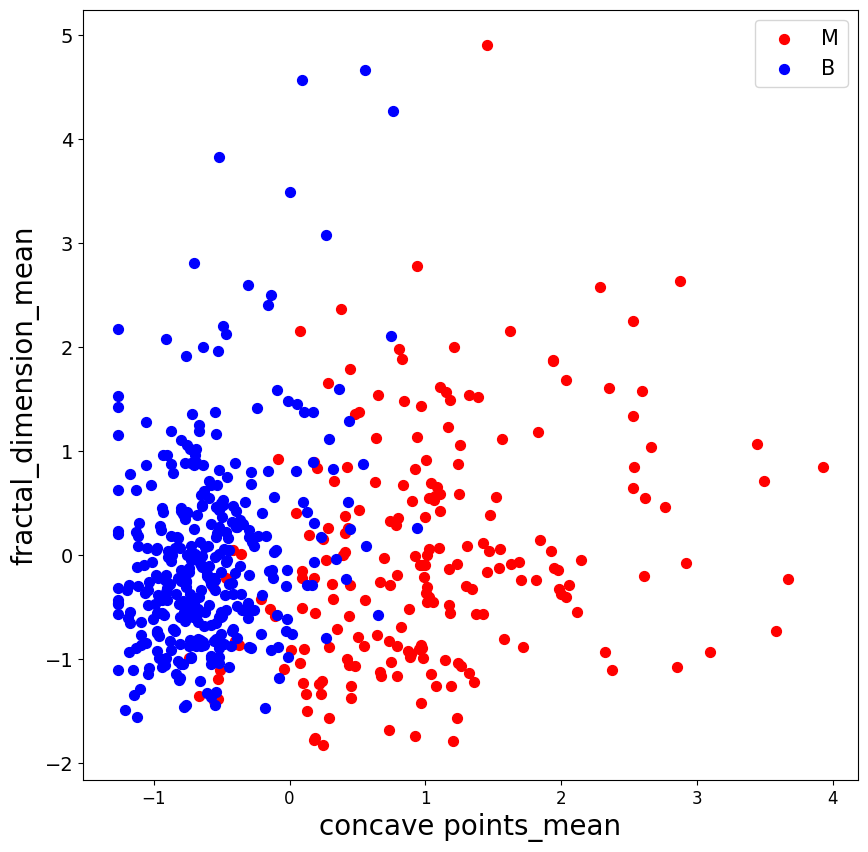

In [21]:
# plot an X-Y scatter of two most important
# features identified above and color by classification.
fig = plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel(features[index_PC1],fontsize=20)
plt.ylabel(features[index_PC2],fontsize=20)
targets = ['M', 'B']
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indices = breast_cancer_df['diagnosis'] == target
    plt.scatter(std_breast_df.loc[indices, features[index_PC1]], std_breast_df.loc[indices, features[index_PC2]], c = color, s = 50)
plt.legend(targets,prop={'size': 15})

K-Means clustering is an unsupervised learning tries to group data points into k clusters based purely on their location in feature space; without using the diagnosis labels at all.
The algorithm works iteratively: it randomly places k centroids, assigns each data point to its nearest centroid, recalculates the centroids as the mean of their assigned points, and repeats until convergence. Here we run K-Means on the PCA-transformed data with k=2.

In [22]:
# K-means clustering

#choose k
#perform clustering on PC1 and PC2 only
#initiate model
kmeans_clusters = KMeans(n_clusters = 2)
#fit data to model
kmeans_clusters.fit(pc_breast_df.iloc[: , [0,1]])

# Put centroids and labels into variables.
centroids = kmeans_clusters.cluster_centers_
k_means_labels = kmeans_clusters.labels_


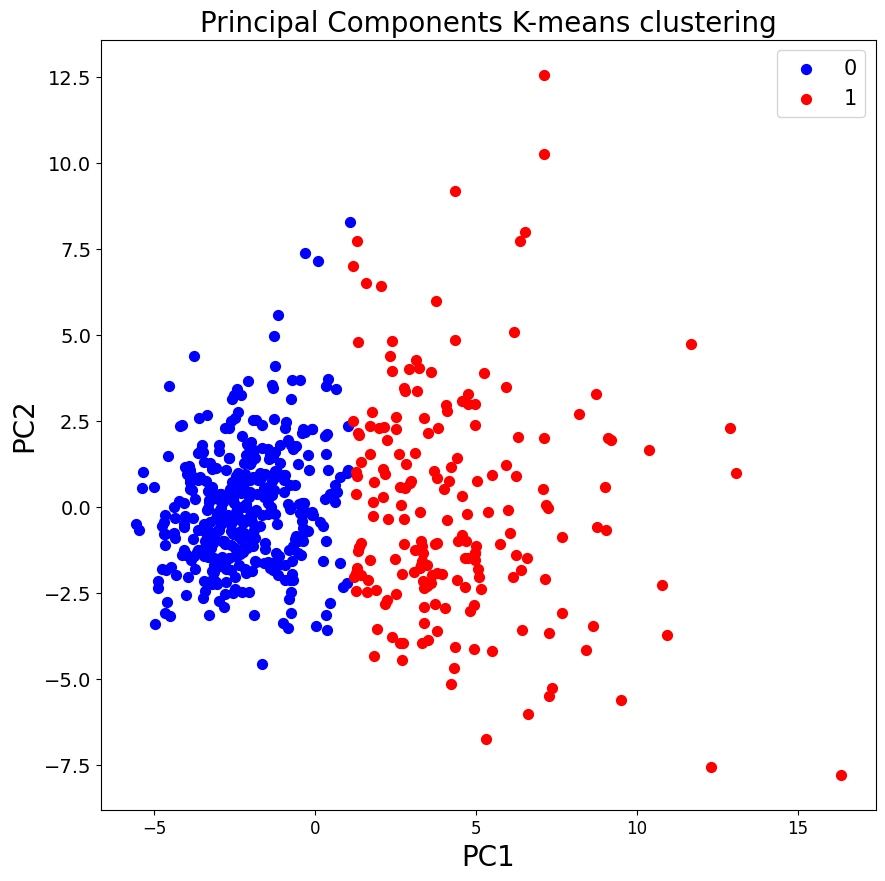

In [23]:
#plot of PC2 by PC1 colored by the K-means classification
fig = plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('PC1',fontsize=20)
plt.ylabel('PC2',fontsize=20)
plt.title("Principal Components K-means clustering",fontsize=20)
targets = [0, 1]
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indices = k_means_labels == target
    plt.scatter(pc_breast_df.loc[indices, 'PC1'], pc_breast_df.loc[indices, 'PC2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})


Compare the plot of PC2 by PC1 colored by the K-means classification and the plot of PC2 and PC1 colored by diagnosis we generated earlier.
